In [11]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.layers import Dense, Activation, MaxPool1D, Conv1D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, InputLayer
from keras.models import Sequential, Model, model_from_json
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from keras import applications
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
import cv2
import glob
%matplotlib inline

In [12]:
def extract_face(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 
    face = face_cascade.detectMultiScale(image)
    for x,y,w,h in face:
        face_image=image[y:y+h,x:x+w]
    face_image = cv2.resize(face_image,(96,96))
    return face_image

In [13]:
X = []
images_list = glob.glob('data/*.jpg')
for file in images_list:
    image = cv2.imread(file)
    face = extract_face(image)
    X.append(face.reshape(96,96,1))
X = np.array(X)
X.shape

(8, 96, 96, 1)

In [14]:
EXTRACT_FEATURES = True
FEATURE_FILE_NAME = "inception_features_temp.npy"
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [15]:
def array_to_img(x):
    rgbimg = cv2.cvtColor(x,cv2.COLOR_GRAY2RGB)
    rgbimg = rgbimg[...,::-1].astype(np.float32)
    a = np.expand_dims(rgbimg, axis=0)
    a = preprocess_input(a)
    return a

In [16]:
# inception_model = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', pooling='avg')
inception_model = applications.resnet50.ResNet50(weights='imagenet', include_top=False, pooling='avg')

In [17]:
inception_features = []
inception_features_array = np.zeros([X.shape[0],2048])

if EXTRACT_FEATURES:
    for i in range(X.shape[0]):
        if(i%10 == 0):
            print('.',end='')
        img = array_to_img(X[i])
        features = inception_model.predict(img)
        inception_features_array[i] = features.flatten()
    file = open(FEATURE_FILE_NAME,"wb")
    np.save(file,inception_features_array)
else:
    file = open(FEATURE_FILE_NAME,'rb')
    inception_features_array = np.load(file)

.

In [18]:
json_file = open("face_model_in1.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.compile(loss="mse", optimizer=keras.optimizers.Adam(),metrics=["accuracy"])

In [19]:
model.load_weights('face_model_in1.h5')

In [23]:
# inception_features_array = np.expand_dims(inception_features_array, axis=2)
# inception_features_array
y = model.predict(inception_features_array.reshape(8,2048))
y.shape

(8, 30)

In [21]:
print(.shape)

(8, 2048, 1)


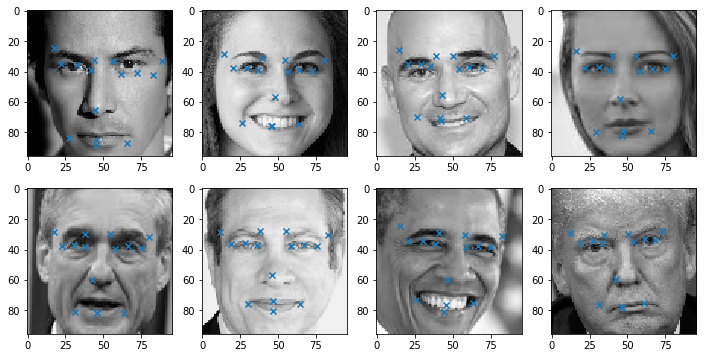

In [24]:
plt.figure(0, figsize=(12,6))
for i in range(1,9):
    plt.subplot(2,4,i)
    plt.imshow(X[i-1,:,:,0], cmap='gray')
    plt.scatter(y[i-1, range(0, 30, 2)], y[i-1, range(1, 30, 2)], marker='x')
plt.show()